In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.io import wavfile
from IPython import display
import librosa.display

### サイン波の音
あらゆる音の中で，最も単純なものはサイン波である．  
標本化周波数を$f_s$とすると，振幅$a$，周波数$f_0$，長さ$L$のサイン波は次のように定義できる．
$$ s(n) = a\sin \left ( 2\pi f_0 t \right ) $$
ここで時間$t$は$ t = \frac{1}{fs} $で表されるので以下の式で表せられる．
$$ s(n) = a\sin \left ( \frac{2\pi f_0 n}{f_s} \right )　(0 \le n < L) $$

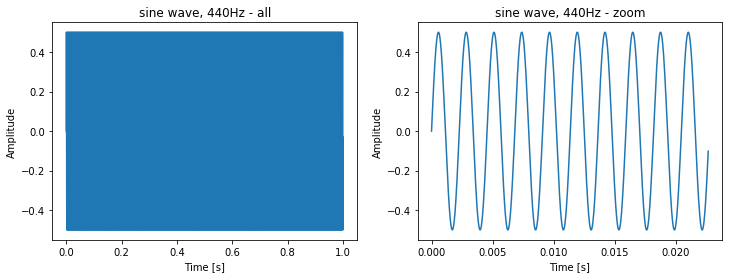

In [60]:
# 標本化周波数8,000Hzとした時の振幅0.5, 周波数1,000Hz, 長さ1sのサイン波を作成
fs = 44100       # 標本化周波数[Hz]
a = 0.5          # 振幅
sec = 1          # 長さ[s]
f_0 = 440        # ラの周波数:440[Hz]

t = np.arange(0, sec, 1/fs)
s = a * np.sin(2.0 * np.pi * f_0 * t)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(t, s)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('sine wave, 440Hz - all')

plt.subplot(122)
plt.plot(t[:1000], s[:1000])
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('sine wave, 440Hz - zoom')
plt.show()

display.Audio(s, rate=fs)

In [23]:
# 16bitのwavファイルに書き出し
wave = (s * float(2 ** 15 - 1)).astype(np.int16)  # 値域を16bitにする
wavfile.write('./src/sine.wav', fs, wave)

In [32]:
# wavファイルの読み込み
sampling_rate, data_raw = wavfile.read('./src/sine.wav')
print('sampling rate:', sampling_rate)
print('raw data:', data_raw, 'dtype=' + str(data_raw.dtype))

sampling rate: 44100
raw data: [    0  1026  2048 ... -3063 -2048 -1026] dtype=int16


In [38]:
# 時間をindexに指定
generated = pd.DataFrame({'time': np.arange(0, 1, 1/sampling_rate)}).set_index('time')
generated['sine'] = np.sin(2 * np.pi * f_0 * generated.index)  # sin波
generated.head()

,sine
time,
0.000000,0.000000
0.000023,0.062648
0.000045,0.125051
0.000068,0.186961
0.000091,0.248138


## 音の強弱を調整

In [42]:
# 減衰を表現
dr = 0.2
decay_emvelope = np.exp(- generated.index / dr)
generated['decay_sine'] = generated['sine'] * decay_emvelope
generated.head()

,sine,decay_sine
time,,
0.000000,0.000000,0.000000
0.000023,0.062648,0.062641
0.000045,0.125051,0.125022
0.000068,0.186961,0.186898
0.000091,0.248138,0.248025


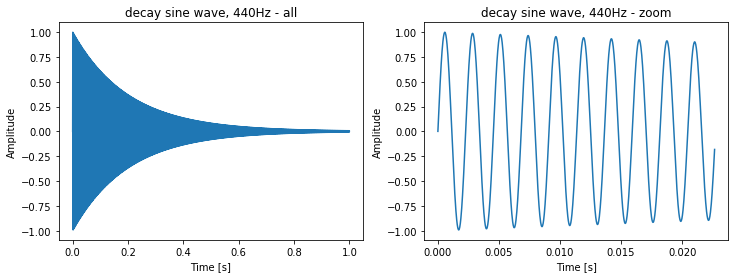

In [62]:
# 16bitのwavファイルに書き出し
wave = (generated['decay_sine'] * float(2 ** 15 - 1)).astype(np.int16)  # 値域を16bitにする
wavfile.write('./src/decay_sine.wav', fs, wave)

# プロット
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(generated.index, generated['decay_sine'])
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('decay sine wave, 440Hz - all')

plt.subplot(122)
plt.plot(generated.index[:1000], generated['decay_sine'].iloc[:1000])
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('decay sine wave, 440Hz - zoom')
plt.show()

display.Audio(generated['decay_sine'], rate=fs)

## 打楽器(スネアドラム)の音

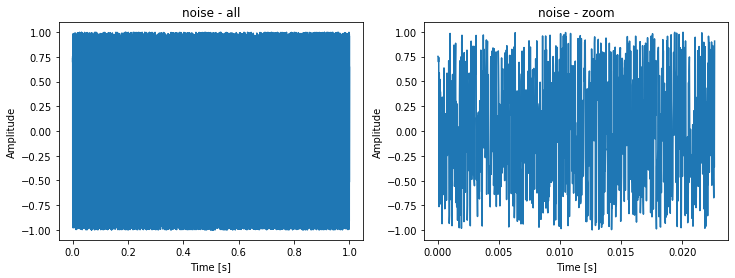

In [63]:
generated['noise'] = np.random.uniform(low=-1, high=1, size=generated.index.shape)
wave = (generated['noise'] * float(2 ** 15 - 1)).astype(np.int16)  # 値域を16bitにする
wavfile.write('./src/noise.wav', fs, wave)

# プロット
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(generated.index, generated['noise'])
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('noise - all')

plt.subplot(122)
plt.plot(generated.index[:1000], generated['noise'].iloc[:1000])
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('noise - zoom')
plt.show()

display.Audio(generated['noise'], rate=fs)

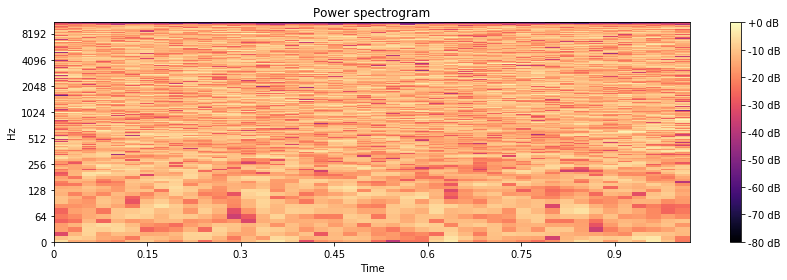

In [66]:
y, sr = librosa.load('./src/noise.wav')  # 読み込み
S = np.abs(librosa.stft(y))              # 短時間フーリエ変換

# スペクトログラムを描画(白色雑音なのでどの周波数帯域にも満遍なく信号が見られる)
plt.figure(figsize=(12, 4))
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), x_axis='time', y_axis='log')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

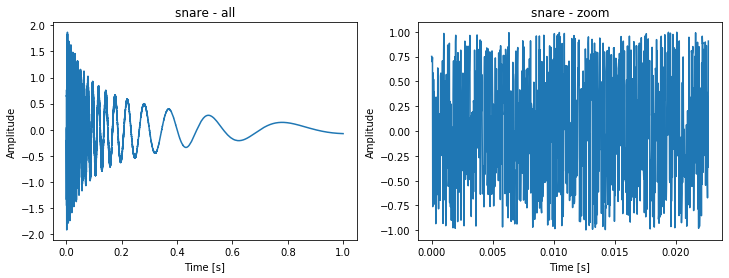

In [67]:
# スネアドラムを作成
short_decay = np.exp(- generated.index / 0.05)
snare_base = np.sin( (1 / (generated.index + 0.1) + 30 ) * 4 * np.pi) * np.exp(- generated.index / 0.4)
generated['snare'] = snare_base + generated['noise'] * short_decay

wave = (generated['snare'] * float(2 ** 15 - 1)).astype(np.int16)  # 値域を16bitにする
wavfile.write('./src/snare.wav', fs, wave)

# プロット
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(generated.index, generated['snare'])
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('snare - all')

plt.subplot(122)
plt.plot(generated.index[:1000], generated['noise'].iloc[:1000])
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('snare - zoom')
plt.show()

display.Audio(generated['snare'], rate=fs)